# Problem
Implement a clustering algorithm and different clustering quality measurements.
For each dataset calculate dependence of chosen clustering quality measurements on number of clusters.
Plot clustering result and real class distribution. Perform PCA projection for non two dimensional datasets before visualization but after clustering.

The following features are included: 
 - K-means clustering
 - Mean Centroid Distance
 - Mean Inner cluster Distance
 - PCA
 - Data prep with the option to normalize or to standardize (effects the result) 
 - Display data methods


In [467]:
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import math
import operator
import csv

In [468]:
# data preperation class 
class data_prep:                                 #Data preparation and normalization for the model 
    def __init__(self,data):
        self.data = self.load(data)
        
    def load(self,data):
        rows = []
        with open(data, newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
            for row in spamreader:
                x = row[0].split(",")
                rows.append(x)
        return rows
               
    def transform(self):
        data = self.data[1:]
        X_final = []
        Y_final = []
        for w in range(len(data)):
            X = data[w][:-1]
            Y = data[w][-1]
            for y in range(len(X)):
                X[y] = float(X[y]) 
            X_final.append(X)
            Y_final.append(Y)   
        numberizer = {}
        number = 0
        for z in Y_final: 
            if z not in numberizer: 
                numberizer[z] = number
                number += 1
        for x in range(len(Y_final)): 
            Y_final[x] = numberizer[Y_final[x]]  
        self.transformedX = np.array(X_final)
        self.transformedY = np.array(Y_final,ndmin=2).T
    
    def normalize(self):
        holder = self.transformedX.T
        for x in holder:
            maxi = max(x)
            mini = min(x)
            for z in range (len(x)):
                x[z] =  (x[z]- mini)/ (maxi - mini)
        self.X = holder.T
        
    def standardize(self):
        holder = self.transformedX.T
        for x in holder:
            mean = np.mean(x)
            std = np.std(x)
            for z in range (len(x)):
                x[z] =  (x[z]-mean)/ std
        self.X = holder.T

In [469]:
class cluster_creator:
    def __init__(self,X):
            self.X = X
            self.N = len(X)
            self.D = len(X.T)
    
    def k_means(self,k):      #Run K-means until convergence and return clusters
        centroids = self.init_centroids_2(k)
        groupLabels = self.group_data(centroids,k)
        while True: 
            new_centroids = self.calc_centroids(groupLabels,k)
            new_groupLabels = self.group_data(new_centroids,k)
            if np.array_equal(new_groupLabels,groupLabels): 
                break
            else: 
                groupLabels = new_groupLabels
        self.k_centroids = new_centroids
        self.k_mean = groupLabels
         
    def init_centroids(self,k):    #Two ways to init centroids (V2 seems more stable)
        centroids = np.random.uniform(np.min(self.X.T[0]),np.max(self.X.T[0]),k)
        for x in range(1,self.D):
            centroids = np.concatenate((centroids,np.random.uniform(np.min(self.X.T[x]),np.max(self.X.T[x]),k)))
        return centroids.reshape(self.D,k).T
    
    def init_centroids_2(self,k):
        a = np.arange(self.N)
        np.random.shuffle(a)
        return(np.take(self.X, a[:k],axis=0))
    
    def group_data(self,centroids,k):      # Find the shortest centroid for all points
        result = []
        for x in range(k):
            result.append(np.sum((self.X-centroids[x])**2,axis=1) /self.D)
        result = np.array(result).T
        return np.argmin(result,axis = 1)
    
    def calc_centroids(self,groupLabels,k):   #Cluster can become empty!                          
        centroids = []                        # Throws errors for high k.
        for x in range(k):                    # Calcs Centroids based on current labels
            cluster = []
            for y in range(len(groupLabels)):
                if groupLabels[y] == x: 
                    cluster.append(self.X[y])
            assert cluster, "Empty Cluster detected. Please run again or choose less k"
            cluster = np.array(cluster)
            centroids.append(np.mean(cluster,axis=0))
        return np.array(centroids)
    
    def mean_centroid_distance(self):   #2 metrics to evaluate the clusters
        mean = 0 
        for x in range(len(self.k_centroids)): 
            cen = np.delete(self.k_centroids, x, axis=0)
            mean += np.mean((cen - self.k_centroids[x])**2 )
        return mean/len(self.k_centroids)
    
    def mean_inner_cluster_distance(self):
        classes = {}
        for x in range(self.N):
            if self.k_mean[x] in classes: 
                classes[self.k_mean[x]].append(self.X[x])
            else: 
                classes[self.k_mean[x]] = [self.X[x] ]
        means = []        
        for key in classes: 
            mean = []
            for x in range(len(classes[key])): 
                cen = np.delete(np.array(classes[key]), x, axis=0)
                mean.append( np.mean((cen - np.array(classes[key])[x])**2 ))
            mean = np.mean(np.array(mean))
            means.append(mean)
        return (np.mean(np.array(means)))
    
    def cov(self):
        mean = np.mean(self.X,axis = 0)
        X = self.X-mean
        return np.dot(X.T,X) * (1/(self.N-1))
          
    def pca(self):         #Return the new DataPoints transformed to 2 Dimensions
        cov = self.cov()
        eig_vals, eig_vecs = np.linalg.eig(cov)
        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
        eig_pairs.sort()
        eig_pairs.reverse()
        matrix_w = np.hstack((eig_pairs[0][1].reshape(self.D,1), 
                      eig_pairs[1][1].reshape(self.D,1)))
        return  self.X.dot(matrix_w)

    def graph(self,labels):             #display the clusters 
        markers = ["+","_","s","P","x","1","2","3","4","8"]
        colors = ["b","g","r","c","m","y","k","b","g","red"]
        classes = {}
        if self.D > 2:
            self.X_pca = self.pca()
            for x in range(self.N):
                if labels[x] in classes: 
                    classes[labels[x]].append(self.X_pca[x])
                else: 
                    classes[labels[x]] = [self.X_pca[x] ]   
        else:
            for x in range(self.N):
                if labels[x] in classes: 
                    classes[labels[x]].append(self.X[x])
                else: 
                    classes[labels[x]] = [self.X[x] ]  
          
        for key in range(len(classes)): 
            cluster = np.array(classes[key])
            plt.plot(cluster.T[0],cluster.T[1],marker=markers[key] \
                     ,color=colors[key],linestyle="None")
        plt.show()
    
    def evaluate_clusters (self):  
        distance1 = self.mean_centroid_distance()
        distance2 = self.mean_inner_cluster_distance()
        return distance1,distance2
        
    def draw_clusters(self,Truelabels):
        print("True Distribution:")
        self.graph(Truelabels)
        print("K-means result:")
        self.graph(self.k_mean)       

Dataset: assistants, Clusters: 2
True Distribution:


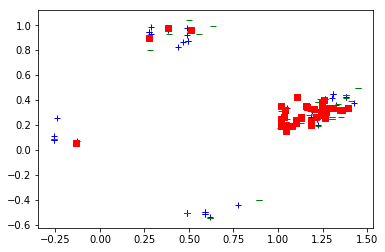

K-means result:


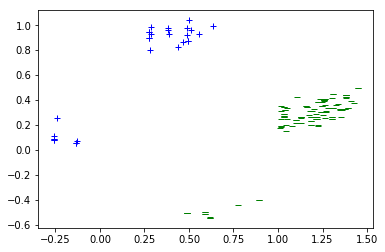

Dataset: assistants, Clusters: 3
True Distribution:


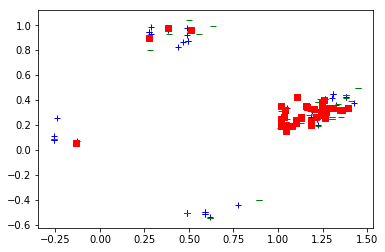

K-means result:


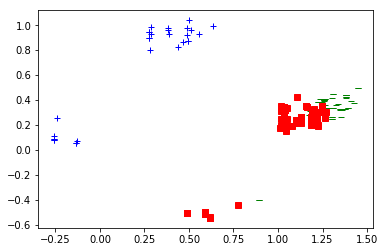

Dataset: assistants, Clusters: 4
True Distribution:


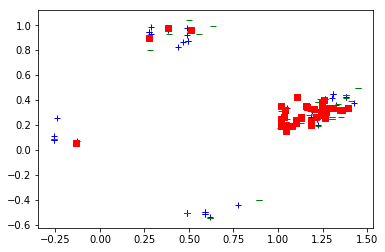

K-means result:


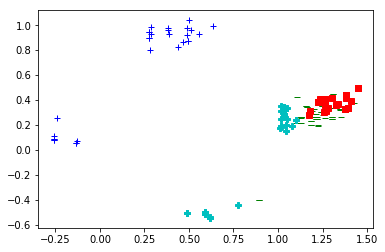

Dataset: crabs, Clusters: 2
True Distribution:


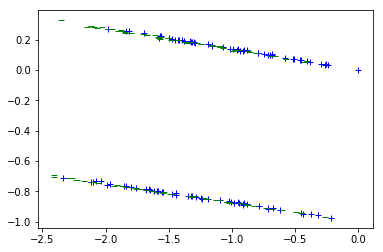

K-means result:


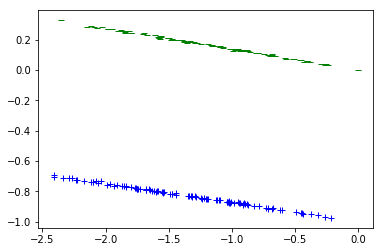

Dataset: crabs, Clusters: 3
True Distribution:


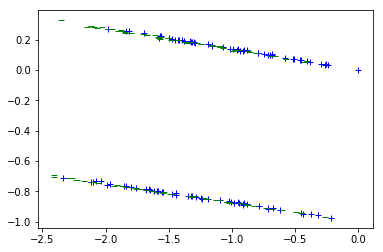

K-means result:


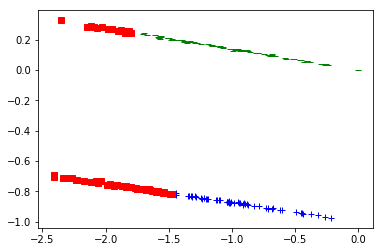

Dataset: crabs, Clusters: 4
True Distribution:


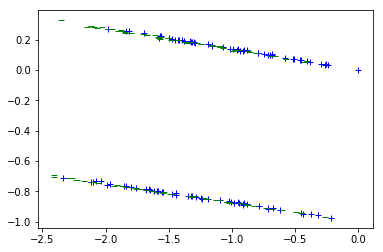

K-means result:


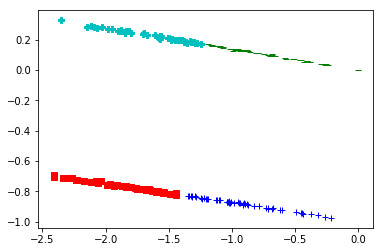

Dataset: ecoli, Clusters: 2
True Distribution:


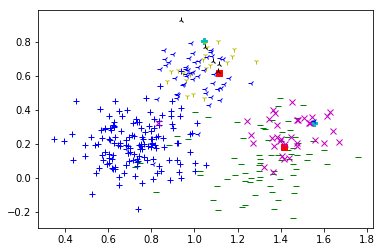

K-means result:


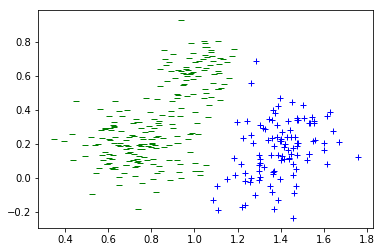

Dataset: ecoli, Clusters: 3
True Distribution:


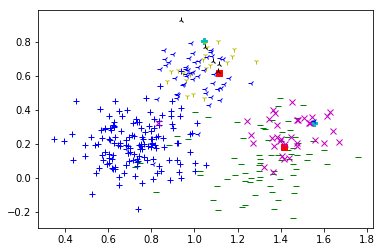

K-means result:


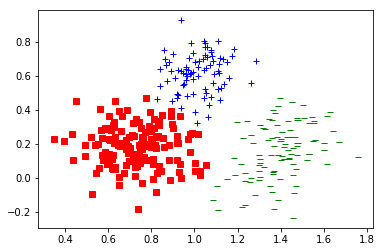

Dataset: ecoli, Clusters: 4
True Distribution:


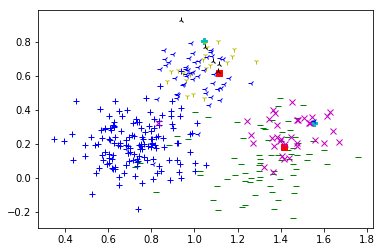

K-means result:


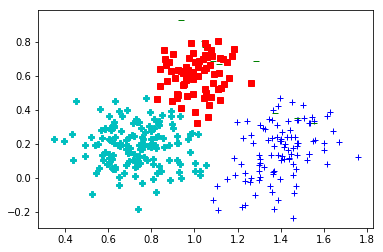

Dataset: haberman, Clusters: 2
True Distribution:


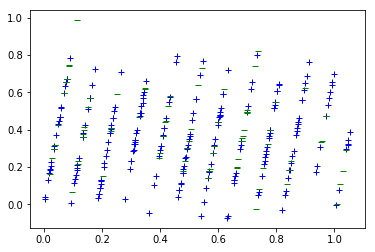

K-means result:


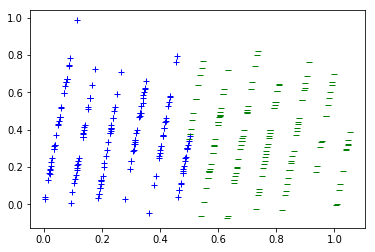

Dataset: haberman, Clusters: 3
True Distribution:


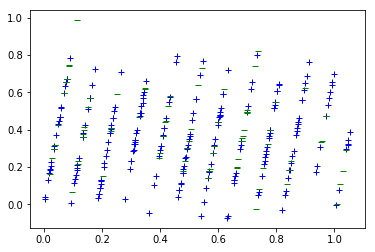

K-means result:


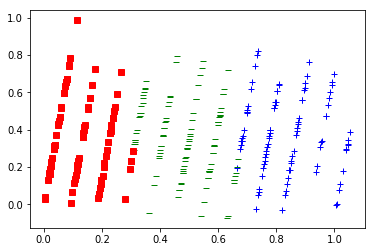

Dataset: haberman, Clusters: 4
True Distribution:


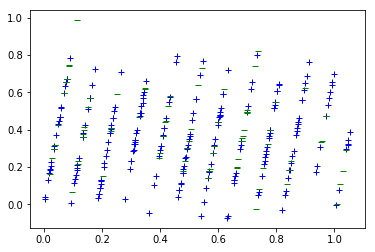

K-means result:


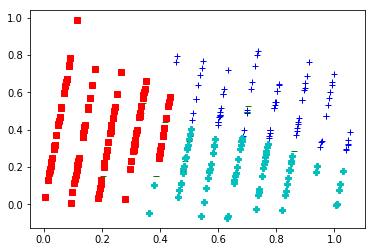

Dataset: tae, Clusters: 2
True Distribution:


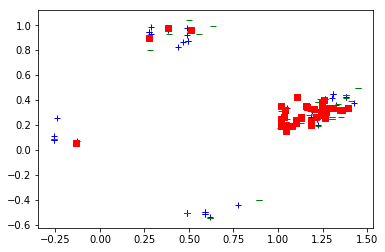

K-means result:


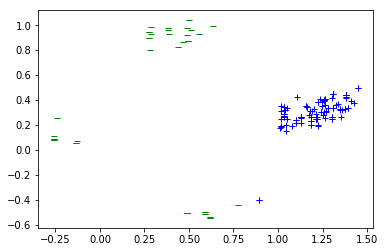

Dataset: tae, Clusters: 3
True Distribution:


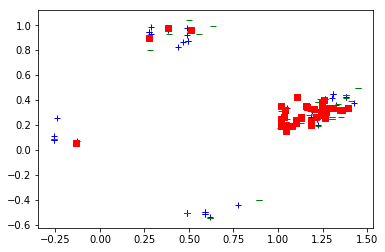

K-means result:


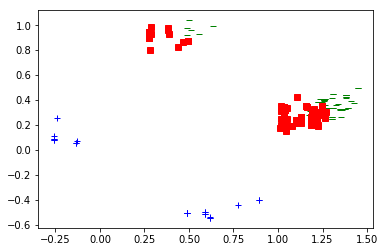

Dataset: tae, Clusters: 4
True Distribution:


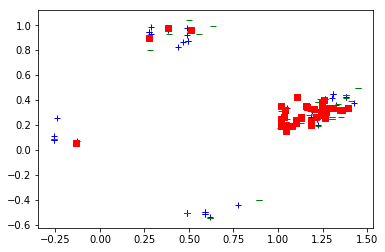

K-means result:


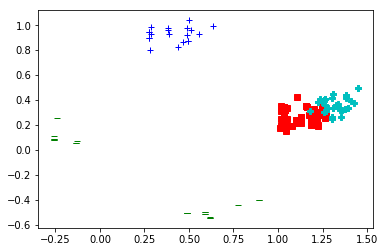

Dataset: vinnie, Clusters: 2
True Distribution:


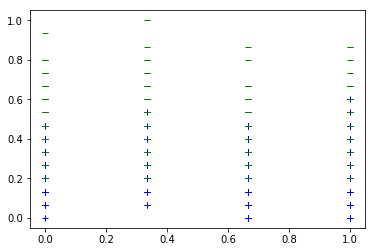

K-means result:


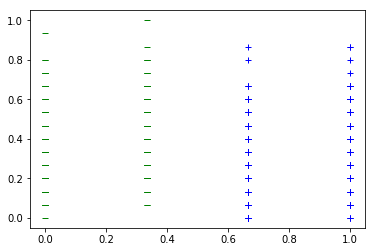

Dataset: vinnie, Clusters: 3
True Distribution:


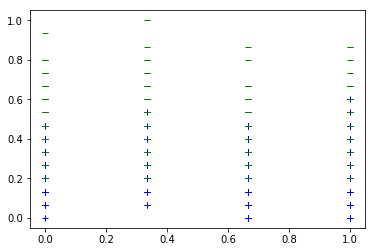

K-means result:


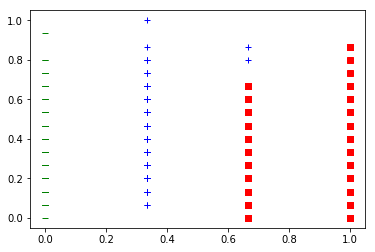

AssertionError: Empty Cluster detected. Please run again or choose less k

In [470]:
dataMod = "norm" #set norm or std
datasets = ["assistants","crabs","ecoli","haberman","tae","vinnie"]
clusterN = [2,3,4]  #Amounts of culsters
MCD = []
MCID = []
for sets in datasets:    #Run all combinations of clusters and data and display result
    data = data_prep("data/Clust/" + sets + ".csv")
    data.transform()
    if dataMod == "norm":
        data.normalize()
    elif dataMod == "std":
        data.standardize()       
    CL = cluster_creator(data.X)
    metric1 = []
    metric2 = []
    for x in clusterN:
        CL.k_means(x)
        print("Dataset: " + str(sets) + ", Clusters: " + str(x))
        CL.draw_clusters(data.transformedY.T[0])
        m1,m2 = CL.evaluate_clusters()
        metric1.append(m1)
        metric2.append(m2)
    MCD.append(metric1)
    MCID.append(metric2)
out1 = pd.DataFrame(MCD,index = datasets,columns = clusterN)
out2 = pd.DataFrame(MCID,index = datasets,columns = clusterN)
print("Mean Centroid Distance:")
print(out1)
print(" ")
print("Mean Inner Cluster Distance:")
print(out2)

        
        
        
        

True Distribution:


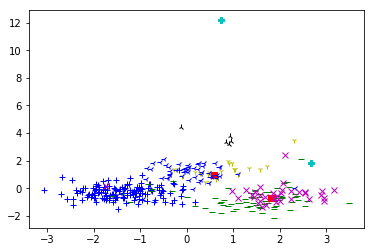

K-means result:


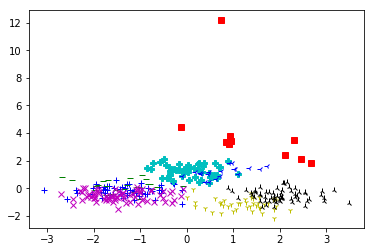

In [466]:
data = data_prep("data/Clust/ecoli.csv")
data.transform()
data.standardize()
CL = cluster_creator(data.X)
CL.k_means(8)
CL.evaluate_clusters()
CL.draw_clusters(data.transformedY.T[0])